In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use('ggplot')

## Load Data

In [3]:
data_path = "./per_station.xlsx"
data = pd.read_excel(data_path)

# Extract the 'sc4' column data
sc_data = data['sc4'].values

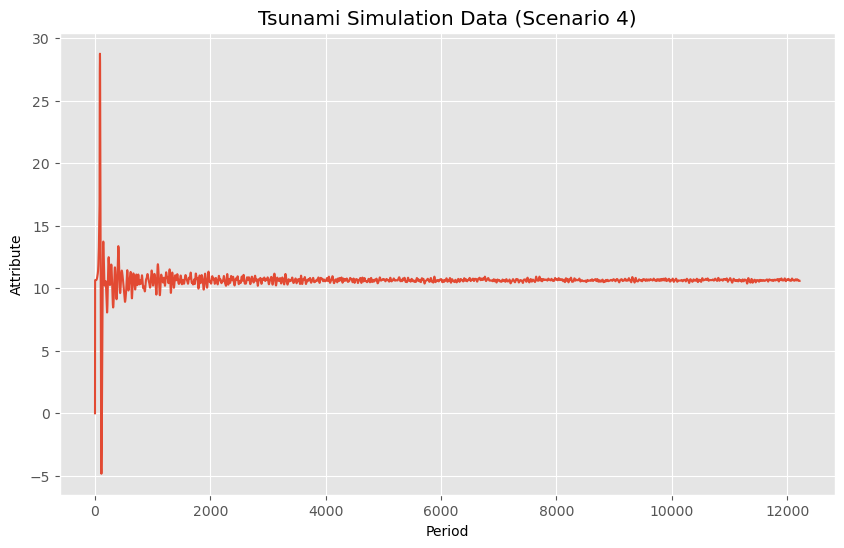

In [4]:
# Generate dummy data
series_data = sc_data[:]

# Plot the dummy data
plt.figure(figsize=(10, 6))
plt.plot(series_data, linestyle='-')
plt.title('Tsunami Simulation Data (Scenario 4)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.grid(True)
plt.show()

## Prepare Data

In [5]:
def prepare_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Prepare the data
X, y = prepare_data(series_data, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.Tensor(X).unsqueeze(-1)  # Add an extra dimension for the input channel
y_tensor = torch.Tensor(y).unsqueeze(-1)

## LSTM Experiment

#### Build Model

In [6]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the convolutional layer
        self.conv = nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=3, padding=1)
        
        # Define the LSTM layers
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Transpose input to match Conv1d input format
        x = x.permute(0, 2, 1)  # [batch_size, input_size, sequence_length]

        # Apply convolutional layer
        x = self.conv(x)

        # Reshape the output of the convolutional layer
        x = x.permute(0, 2, 1)  # [batch_size, sequence_length, hidden_size]

        # Apply LSTM layers
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout
        out = self.dropout(out)

        # Apply fully connected layer
        out = self.fc(out[:, -1, :])

        return out

# Define model parameters
input_size = 1
hidden_size = 32
num_layers = 2  # Set the number of layers in the LSTM stack
output_size = 1

# Instantiate the model
model = CNNLSTM(input_size, hidden_size, num_layers, output_size)
print(model)

CNNLSTM(
  (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


#### Train Model

In [7]:
# Define training parameters
num_epochs = 100
learning_rate = 0.001
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store losses
losses = []

# Initialize the best loss as infinity
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    # Shuffle the data and split into batches
    indices = torch.randperm(len(X_tensor))
    X_shuffled = X_tensor[indices]
    y_shuffled = y_tensor[indices]
    
    for i in range(0, len(X_tensor), batch_size):
        
        # Forward pass
        outputs = model(X_shuffled[i:i+batch_size])
        loss = criterion(outputs, y_shuffled[i:i+batch_size])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    
    # Average epoch loss
    epoch_loss /= (len(X_tensor) / batch_size)
    losses.append(epoch_loss)
    
    # Save the model if this epoch's loss is the best we've seen so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {epoch_loss:.6f}')

Epoch [1/100], MSE Loss: 22.302946
Epoch [2/100], MSE Loss: 3.730910
Epoch [3/100], MSE Loss: 3.644210
Epoch [4/100], MSE Loss: 3.572421
Epoch [5/100], MSE Loss: 3.481671
Epoch [6/100], MSE Loss: 3.451941
Epoch [7/100], MSE Loss: 3.406408
Epoch [8/100], MSE Loss: 3.304074
Epoch [9/100], MSE Loss: 3.106001
Epoch [10/100], MSE Loss: 3.100349
Epoch [11/100], MSE Loss: 2.907640
Epoch [12/100], MSE Loss: 2.913790
Epoch [13/100], MSE Loss: 2.803322
Epoch [14/100], MSE Loss: 2.615257
Epoch [15/100], MSE Loss: 2.504030
Epoch [16/100], MSE Loss: 2.350559
Epoch [17/100], MSE Loss: 2.244748
Epoch [18/100], MSE Loss: 2.134047
Epoch [19/100], MSE Loss: 1.986697
Epoch [20/100], MSE Loss: 1.881451
Epoch [21/100], MSE Loss: 1.750765
Epoch [22/100], MSE Loss: 1.687301
Epoch [23/100], MSE Loss: 1.581241
Epoch [24/100], MSE Loss: 1.478682
Epoch [25/100], MSE Loss: 1.380036
Epoch [26/100], MSE Loss: 1.252958
Epoch [27/100], MSE Loss: 1.179530
Epoch [28/100], MSE Loss: 1.105289
Epoch [29/100], MSE Loss: 1.

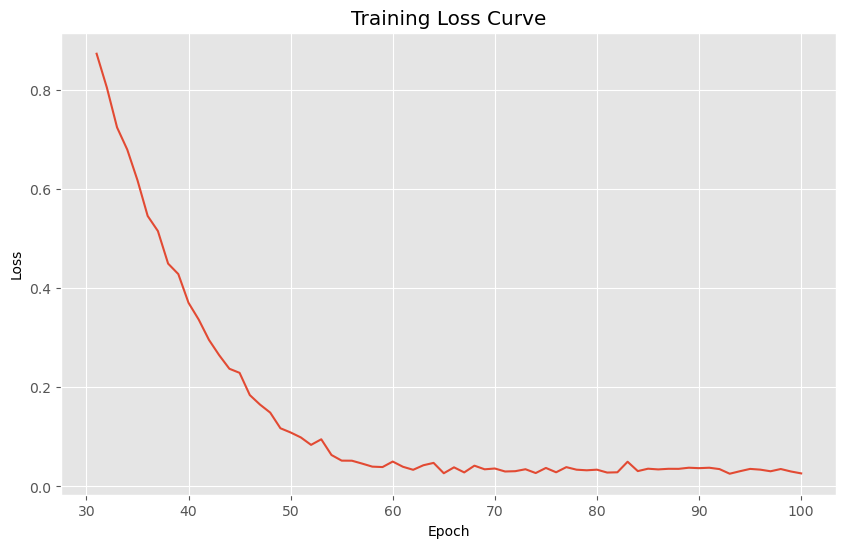

In [8]:
# Plot learning curve
offset = 30

plt.figure(figsize=(10, 6))
plt.plot(range(offset+1, num_epochs+1), losses[offset:], linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### Evaluate Model

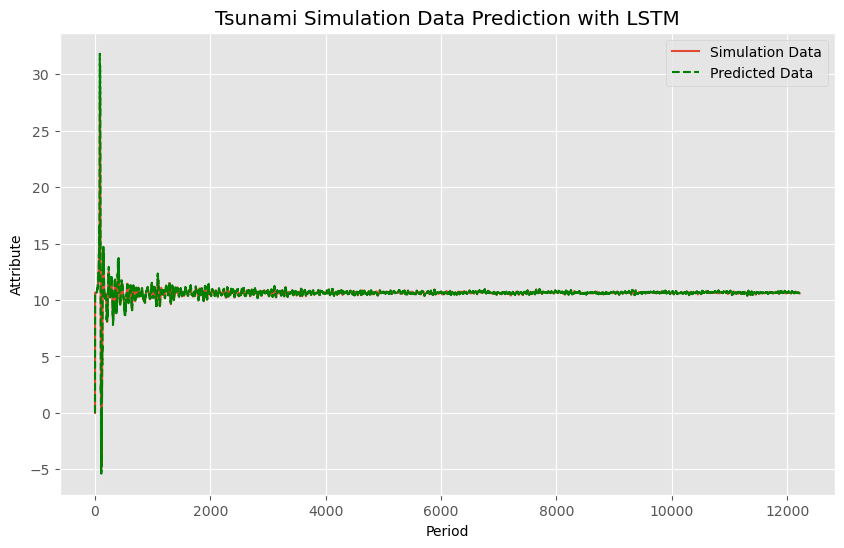

In [9]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

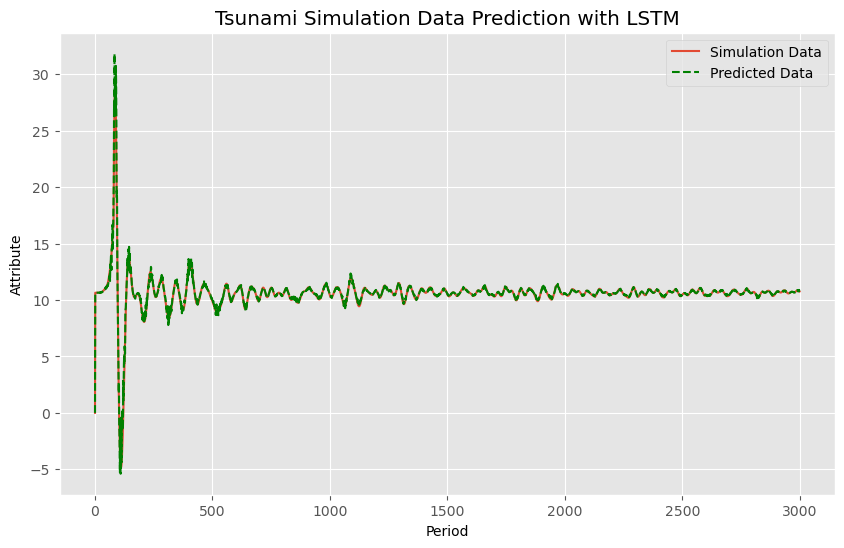

In [10]:
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.02435068185143983
Mean Absolute Error (MAE): 0.03736680789872749


## Test S1, S2, S3

In [12]:
sc_data = data['sc1'].values
series_data = sc_data[:]

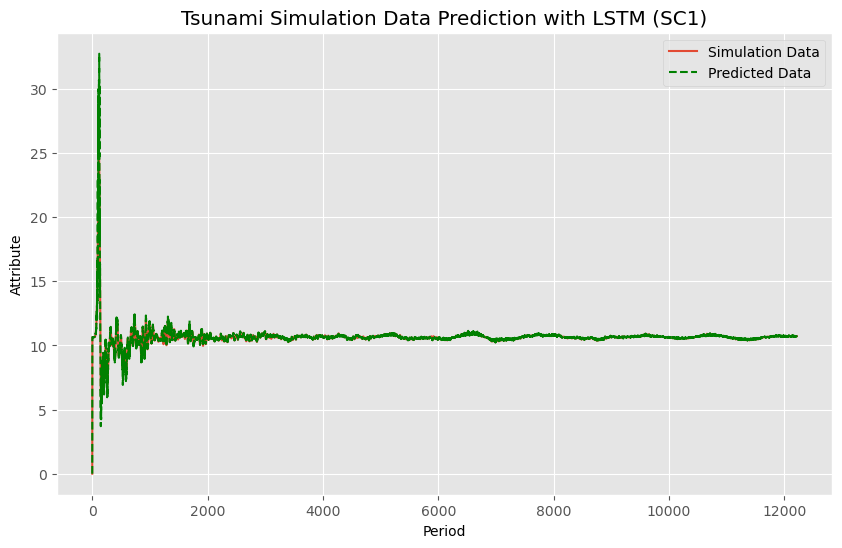

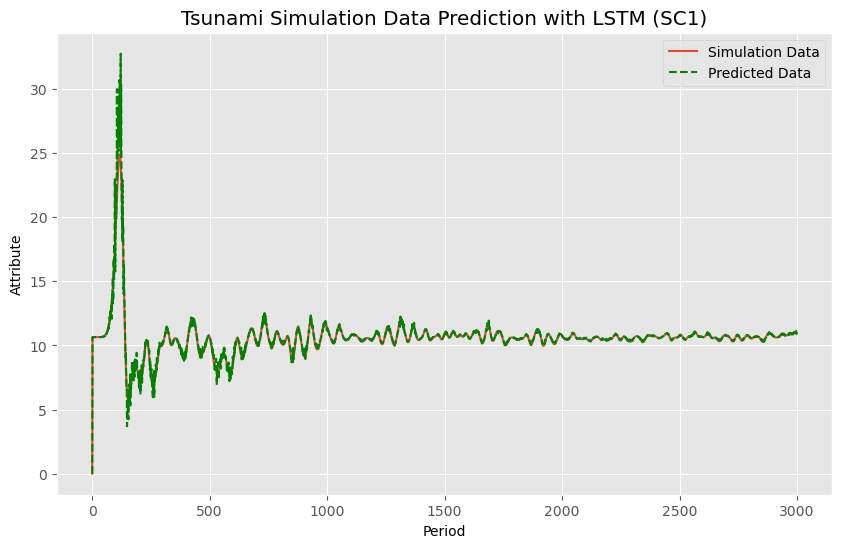

In [13]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC1)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC1)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC1 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC1 Mean Absolute Error (MAE):", mae)

SC1 Mean Squared Error (MSE): 0.04740135832040256
SC1 Mean Absolute Error (MAE): 0.04911687388540146


In [15]:
sc_data = data['sc2'].values
series_data = sc_data[:]

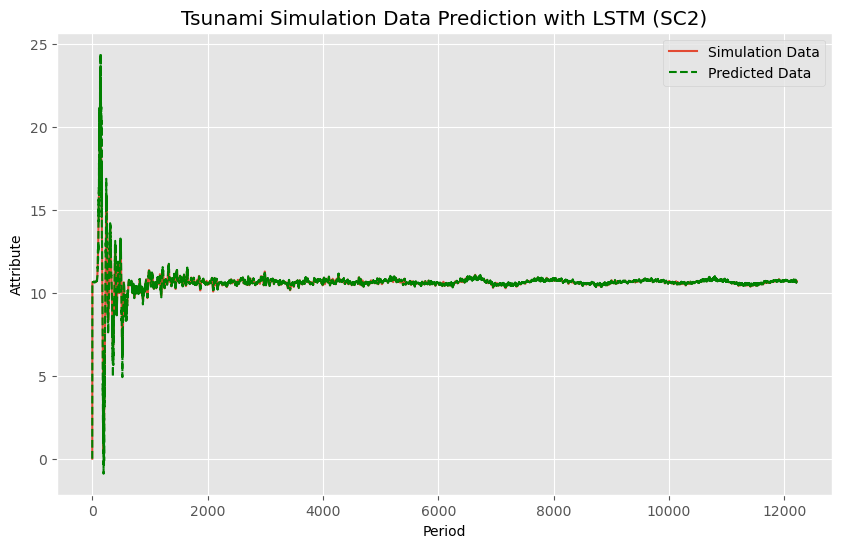

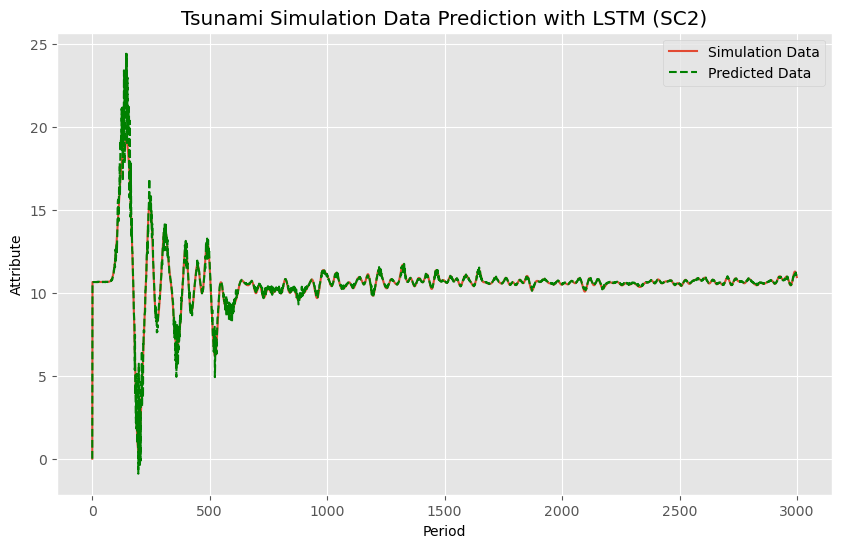

In [16]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC2)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC2)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC2 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC2 Mean Absolute Error (MAE):", mae)

SC2 Mean Squared Error (MSE): 0.042249496721168726
SC2 Mean Absolute Error (MAE): 0.049241925102180714


In [18]:
sc_data = data['sc3'].values
series_data = sc_data[:]

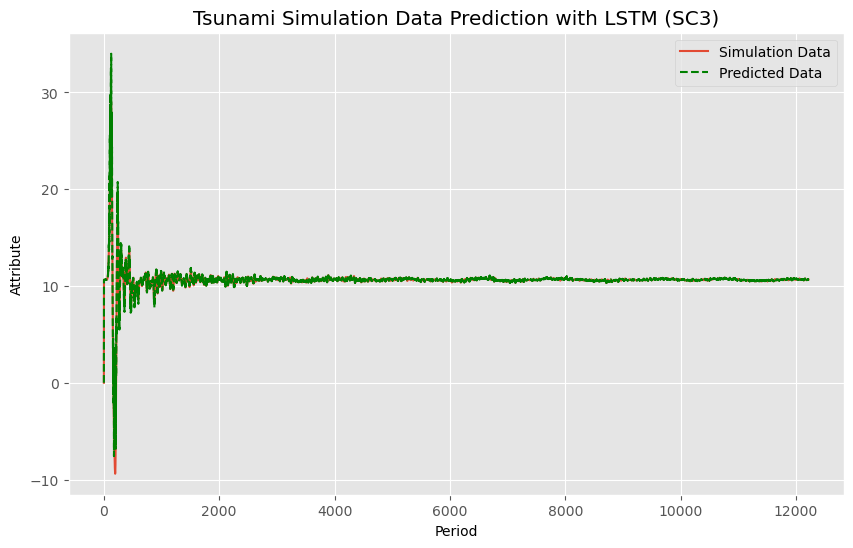

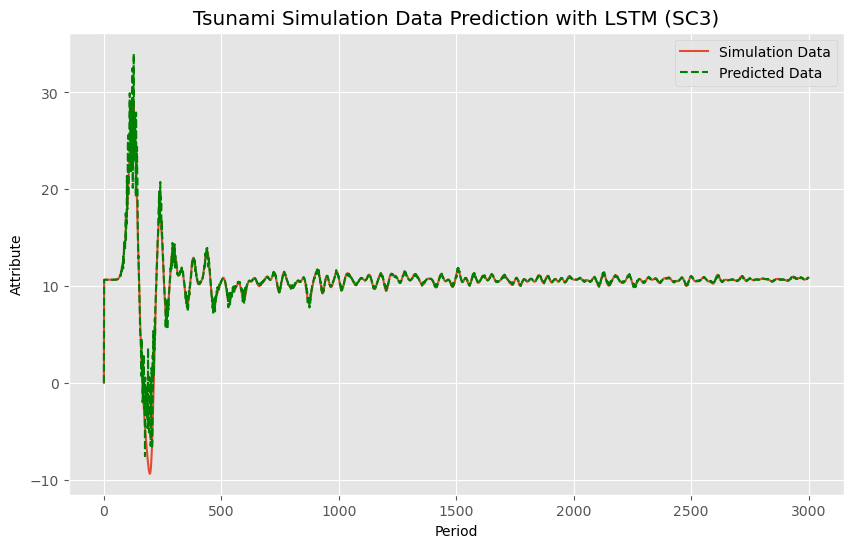

In [19]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC3)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC3)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC3 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC3 Mean Absolute Error (MAE):", mae)

SC3 Mean Squared Error (MSE): 0.17706551829954895
SC3 Mean Absolute Error (MAE): 0.06829578668345522


---